<a href="https://colab.research.google.com/github/lcambisaca/Volleyball_Handsigns/blob/main/Volleyball_Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PyTorch
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn

# Import matplotlib for visualization
import matplotlib.pyplot as plt


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Gathering Custom Data


In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Volleyball_signs"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "Volleyball_signs.zip", "wb") as f:
      #https://github.com/lcambisaca/Volleyball_Handsigns/raw/refs/heads/main/data/Volleyball_signs.zip
        request = requests.get("https://github.com/lcambisaca/Volleyball_Handsigns/raw/refs/heads/main/data/Volleyball_signs.zip")
        print("Downloading Volleyball...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "Volleyball_signs.zip", "r") as zip_ref:
        print("Unzipping signs data...")
        zip_ref.extractall(image_path)

Did not find data/Volleyball_signs directory, creating one...
Unzipping signs data...


# Transforming data with torchvision.transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 28x28
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.Resize(size=(28, 28)), # H and W to be the same size
    transforms.Grayscale(num_output_channels=1),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/Volleyball_signs/train'),
 PosixPath('data/Volleyball_signs/test'))

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 852
    Root location: data/Volleyball_signs/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 215
    Root location: data/Volleyball_signs/test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
           )


In [ ]:
img, label = train_data[0][0], train_data[0][1]

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['1', '2', '3', '4', 'A', 'Shoot']

Original shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image permute shape: torch.Size([28, 28, 1]) -> [height, width, color_channels]


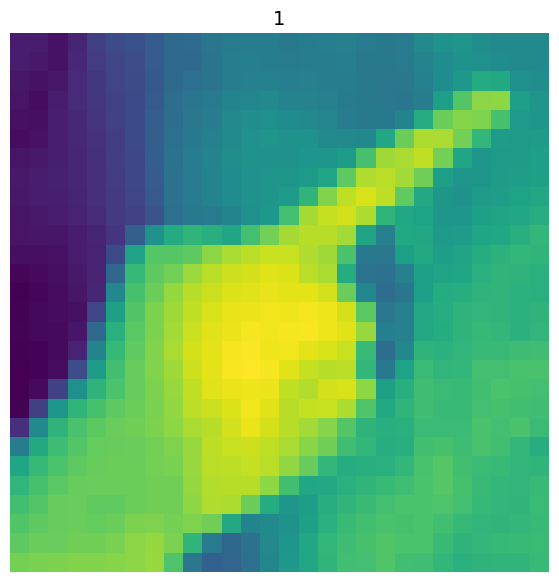

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'1': 0, '2': 1, '3': 2, '4': 3, 'A': 4, 'Shoot': 5}

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(852, 215)

Image shape: torch.Size([28, 28, 1])


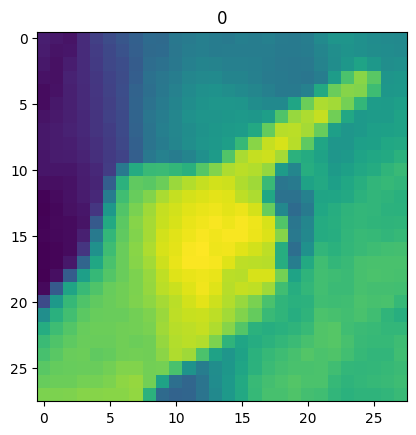

In [ ]:
image, label = train_data[1]
print(f"Image shape: {image.permute(1, 2, 0).shape}") #trtansforms it to 64 64 3 instad of 3 3 64
plt.imshow(image.permute(1, 2, 0))
plt.title(label);

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 16

# Turn datasets into iterables (batches)

train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e21d33233d0>, <torch.utils.data.dataloader.DataLoader object at 0x7e21d3323c40>)
Length of train dataloader: 54 batches of 16
Length of test dataloader: 14 batches of 16


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape


(torch.Size([16, 1, 28, 28]), torch.Size([16]))

#Linear Model


In [ ]:
from torch import nn

class VolleyballModelLinear(nn.Module):
    def __init__(self, input_shape,output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # Flatten the input image to a 1D vector
            nn.Flatten(),

            # Fully connected layers with no activations
            nn.Linear(in_features=input_shape, out_features=256),  # First dense layer
            nn.Linear(in_features=256, out_features=128),   # Second dense layer
            nn.Linear(in_features=128, out_features=output_shape)  # Output layer
        )

    def forward(self, x):
        return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = VolleyballModelLinear(input_shape=28*28, # one for every pixel (28x28)
    output_shape=len(class_names) # one for every class
)

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 125
train_num = []
test_num = []
acc_num = []

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 20 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)


    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
    train_num.append(train_loss)
    test_num.append(test_loss)
    acc_num.append(test_acc)



# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/852 samples
Looked at 320/852 samples
Looked at 640/852 samples

Train loss: 1.79362 | Test loss: 1.76938, Test acc: 21.68%

Epoch: 1
-------
Looked at 0/852 samples
Looked at 320/852 samples
Looked at 640/852 samples

Train loss: 1.76421 | Test loss: 1.74583, Test acc: 23.66%

Epoch: 2
-------
Looked at 0/852 samples
Looked at 320/852 samples
Looked at 640/852 samples

Train loss: 1.74836 | Test loss: 1.72557, Test acc: 32.21%

Epoch: 3
-------
Looked at 0/852 samples
Looked at 320/852 samples
Looked at 640/852 samples

Train loss: 1.72780 | Test loss: 1.69417, Test acc: 30.36%

Epoch: 4
-------
Looked at 0/852 samples
Looked at 320/852 samples
Looked at 640/852 samples

Train loss: 1.70269 | Test loss: 1.67408, Test acc: 41.07%

Epoch: 5
-------
Looked at 0/852 samples
Looked at 320/852 samples
Looked at 640/852 samples

Train loss: 1.67910 | Test loss: 1.65707, Test acc: 35.91%

Epoch: 6
-------
Looked at 0/852 samples
Looked at 320/852 samples
Looked at

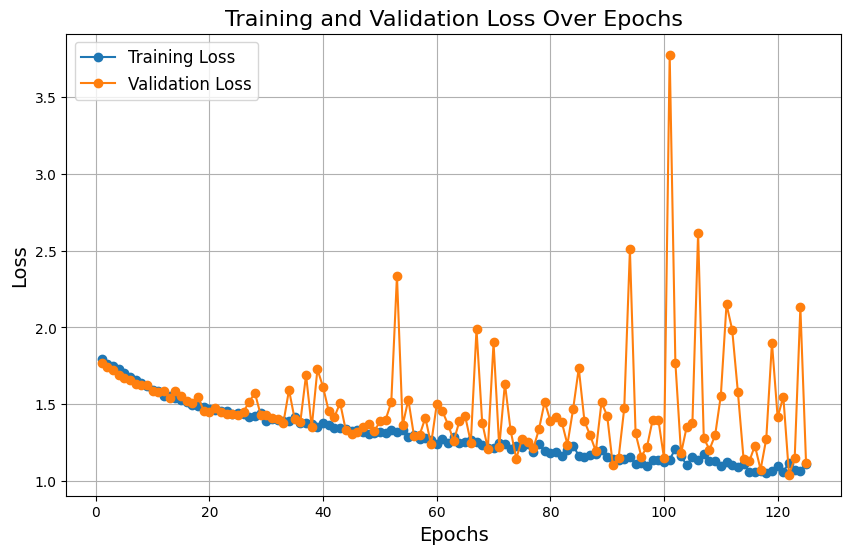

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_num) + 1), [t.detach().numpy() for t in train_num], label='Training Loss', marker='o') # Detach gradients from train_num
plt.plot(range(1, len(test_num) + 1), [t.detach().numpy() for t in test_num], label='Validation Loss', marker='o') # Detach gradients from test_num
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

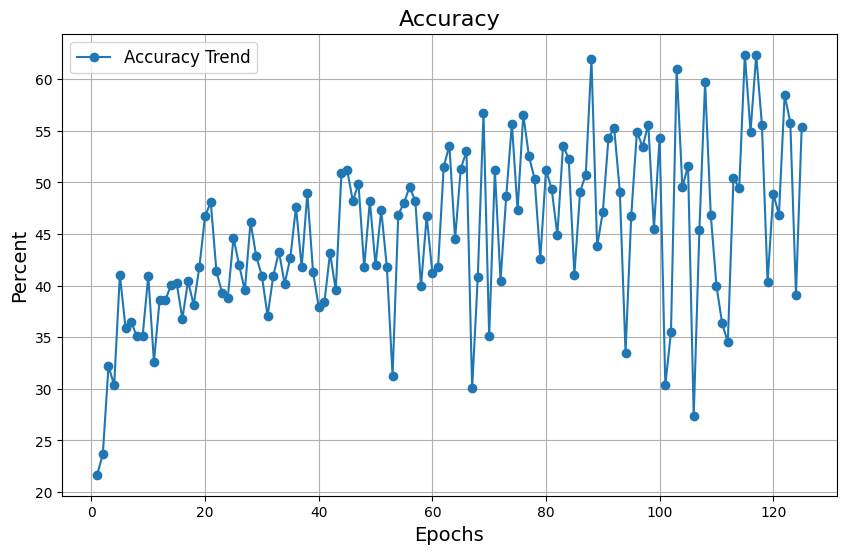

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(acc_num) + 1), acc_num, label='Accuracy Trend', marker='o') # Detach gradients from train_num
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'VolleyballModelLinear',
 'model_loss': 1.1150108575820923,
 'model_acc': 57.142857142857146}

#Model2 with non-linear and linear layers

In [ ]:
from torch import nn

class VolleyballModelNonLinear(nn.Module):
    def __init__(self, input_shape, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # Flatten the input image to a 1D vector
            nn.Flatten(),

            # Fully connected layers with non-linear activations
            nn.Linear(input_shape, out_features=512),  # First hidden layer
            nn.ReLU(),  # Non-linear activation

            nn.Linear(in_features=512, out_features=256),  # Second hidden layer
            nn.ReLU(),  # Non-linear activation

            nn.Linear(in_features=256, out_features=128),  # Third hidden layer
            nn.ReLU(),  # Non-linear activation
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(in_features=128, out_features=output_shape)  # Output layer
            # No activation here because logits are typically used for classification
        )

    def forward(self, x):
        return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)
model_1 = VolleyballModelNonLinear(
    input_shape=28*28, # number of input features
    output_shape=len(class_names) # number of output classes desired
)

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return(train_loss)


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)


        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss , test_acc

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()
test_num = []
train_num = []
acc_num = []


epochs = 125
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_num.append(train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    ))

    temp = test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )
    test_num.append(temp[0])
    acc_num.append(temp[1])

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)



  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.79217 | Train accuracy: 17.13%
Test loss: 1.78048 | Test accuracy: 20.54%

Epoch: 1
---------
Train loss: 1.77534 | Train accuracy: 20.60%
Test loss: 1.75652 | Test accuracy: 34.63%

Epoch: 2
---------
Train loss: 1.73730 | Train accuracy: 25.46%
Test loss: 1.68236 | Test accuracy: 27.68%

Epoch: 3
---------
Train loss: 1.69110 | Train accuracy: 29.28%
Test loss: 1.85249 | Test accuracy: 26.15%

Epoch: 4
---------
Train loss: 1.64763 | Train accuracy: 32.99%
Test loss: 2.32606 | Test accuracy: 20.09%

Epoch: 5
---------
Train loss: 1.59749 | Train accuracy: 33.33%
Test loss: 2.55190 | Test accuracy: 20.98%

Epoch: 6
---------
Train loss: 1.59822 | Train accuracy: 33.33%
Test loss: 1.48628 | Test accuracy: 33.74%

Epoch: 7
---------
Train loss: 1.50952 | Train accuracy: 36.23%
Test loss: 1.68947 | Test accuracy: 26.15%

Epoch: 8
---------
Train loss: 1.47732 | Train accuracy: 37.27%
Test loss: 1.52389 | Test accuracy: 25.89%

Epoch: 9
---------
Train los

In [ ]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results


{'model_name': 'VolleyballModelNonLinear',
 'model_loss': 1.5660163164138794,
 'model_acc': 66.07142857142857}

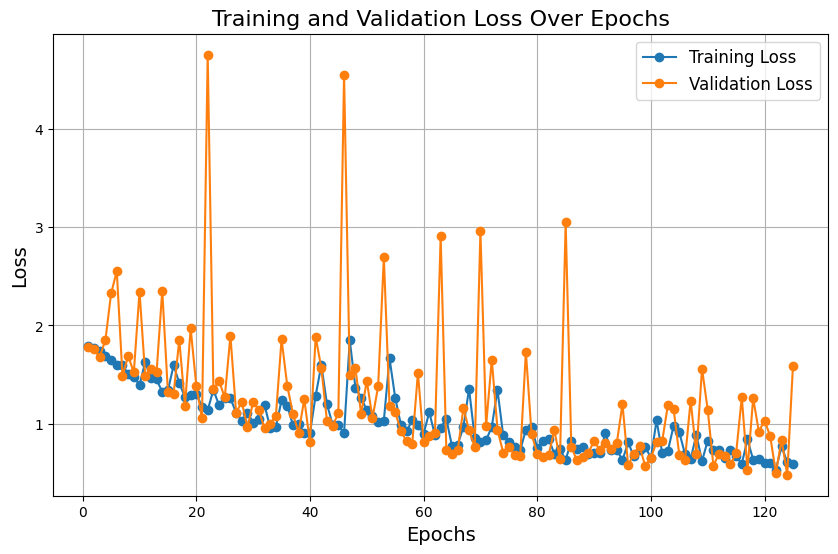

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_num) + 1), [t.detach().numpy() for t in train_num], label='Training Loss', marker='o') # Detach gradients from train_num
plt.plot(range(1, len(test_num) + 1), [t.detach().numpy() for t in test_num], label='Validation Loss', marker='o') # Detach gradients from test_num
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

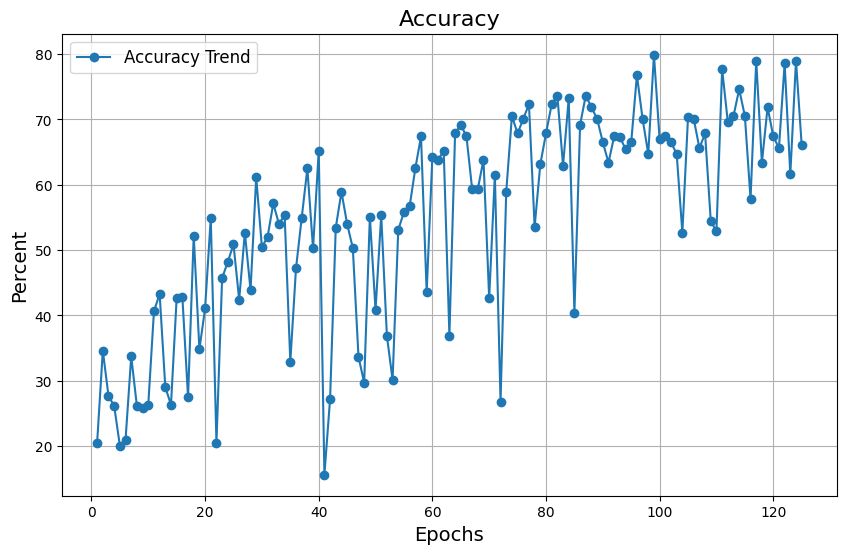

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(acc_num) + 1), acc_num, label='Accuracy Trend', marker='o') # Detach gradients from train_num
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# CNN Network

In [ ]:
# Create a convolutional neural network
class VolleyballModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = VolleyballModelV2(input_shape=1,
    hidden_units=20,
    output_shape=len(class_names)).to(device)
model_2

VolleyballModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=980, out_features=6, bias=True)
  )
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.1)

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()
test_num = []
train_num = []
acc_num = []


# Train and test model
epochs = 50
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_num.append(train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    ))
    temp = test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_num.append(temp[0])
    acc_num.append(temp[1])

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.79483 | Train accuracy: 15.39%
Test loss: 1.78645 | Test accuracy: 20.09%

Epoch: 1
---------
Train loss: 1.78991 | Train accuracy: 17.82%
Test loss: 1.78228 | Test accuracy: 17.86%

Epoch: 2
---------
Train loss: 1.78168 | Train accuracy: 18.06%
Test loss: 1.79291 | Test accuracy: 19.20%

Epoch: 3
---------
Train loss: 1.77630 | Train accuracy: 21.88%
Test loss: 1.73605 | Test accuracy: 20.98%

Epoch: 4
---------
Train loss: 1.69400 | Train accuracy: 30.09%
Test loss: 1.71044 | Test accuracy: 25.70%

Epoch: 5
---------
Train loss: 1.69923 | Train accuracy: 31.37%
Test loss: 1.71653 | Test accuracy: 27.49%

Epoch: 6
---------
Train loss: 1.59144 | Train accuracy: 34.72%
Test loss: 1.41374 | Test accuracy: 43.24%

Epoch: 7
---------
Train loss: 1.32446 | Train accuracy: 45.95%
Test loss: 1.48079 | Test accuracy: 36.35%

Epoch: 8
---------
Train loss: 1.19704 | Train accuracy: 53.24%
Test loss: 1.37138 | Test accuracy: 52.61%

Epoch: 9
---------
Train los

In [ ]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'VolleyballModelV2',
 'model_loss': 0.004797105677425861,
 'model_acc': 100.0}

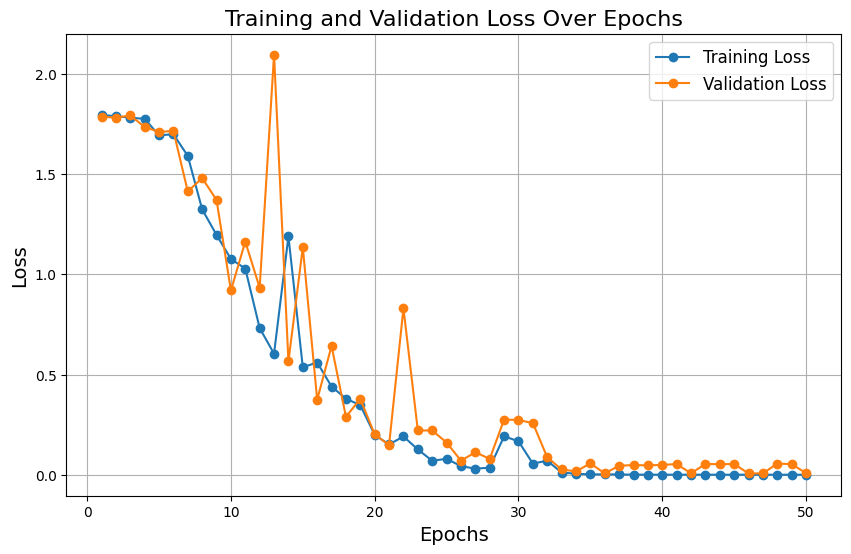

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_num) + 1), [t.detach().numpy() for t in train_num], label='Training Loss', marker='o') # Detach gradients from train_num
plt.plot(range(1, len(test_num) + 1), [t.detach().numpy() for t in test_num], label='Validation Loss', marker='o') # Detach gradients from test_num
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

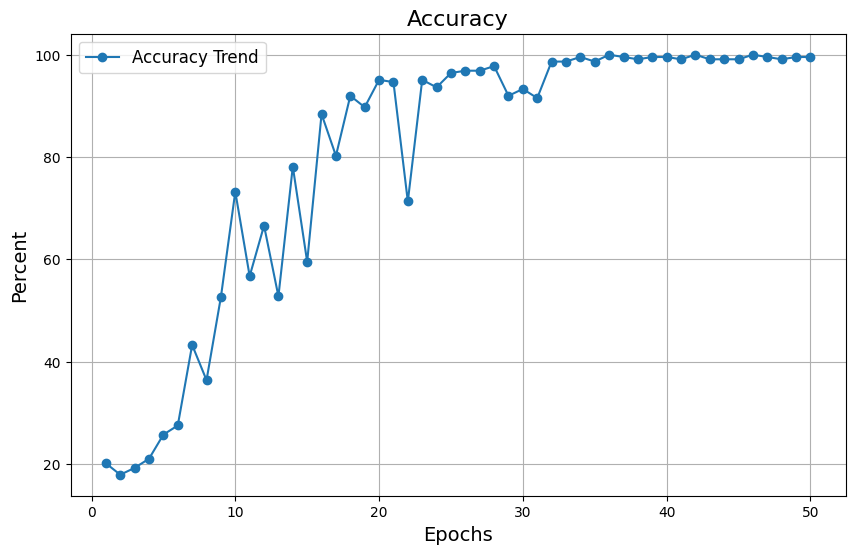

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(acc_num) + 1), acc_num, label='Accuracy Trend', marker='o') # Detach gradients from train_num
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,VolleyballModelLinear,1.115011,57.142857
1,VolleyballModelNonLinear,1.566016,66.071429
2,VolleyballModelV2,0.004797,100.000000


In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 4 (A)


In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.2147e-18, 6.0923e-22, 1.9265e-21, 1.2692e-26, 1.0000e+00, 6.3662e-13],
        [1.0000e+00, 2.0010e-25, 3.1096e-37, 1.2612e-44, 8.7670e-32, 9.0250e-37]])

In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.2147e-18, 6.0923e-22, 1.9265e-21, 1.2692e-26, 1.0000e+00, 6.3662e-13],
        [1.0000e+00, 2.0010e-25, 3.1096e-37, 1.2612e-44, 8.7670e-32, 9.0250e-37]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 0, 0, 5, 1, 1, 1, 1, 5])

In [ ]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([4, 0, 0, 5, 1, 1, 1, 1, 5], tensor([4, 0, 0, 5, 1, 1, 1, 1, 5]))

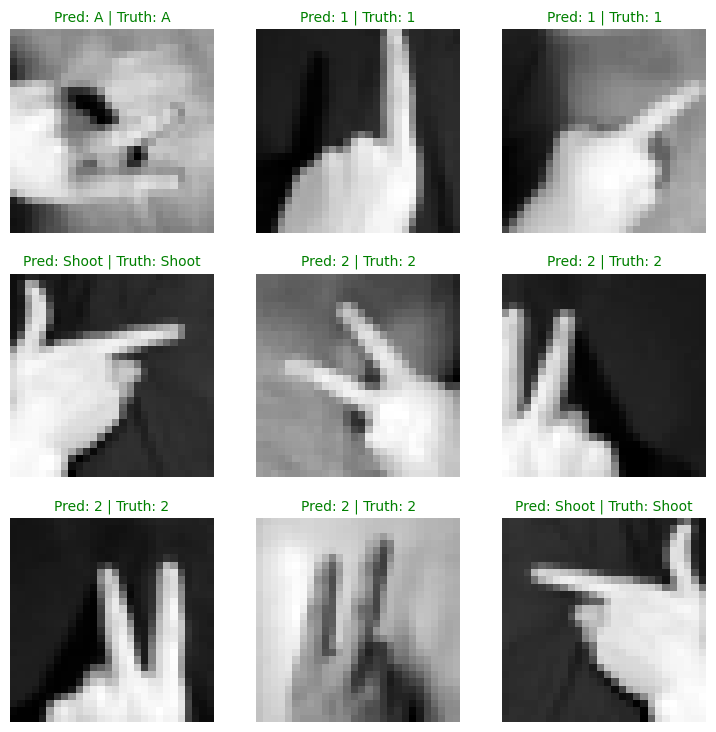

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);